In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
import csv
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots


In [6]:
folder = "../../../data/surveys/responses/"
response_list = glob.glob(F"{folder}*")

folder = "../../../data/surveys/surveys/"
survey_list = [F"{folder}{lst[59:]}" for lst in response_list]

# df = pd.concat((pd.read_csv(f) for f in respons_list), ignore_index=True)

In [7]:
df_survey = pd.read_csv(survey_list[0], sep='\t')
df_survey.rename(columns={ df_survey.columns[0]: "Index" }, inplace = True)
df_response = pd.read_csv(response_list[0], header=None).iloc[: , 1:].T
df_response.rename(columns={ df_response.columns[0]: "Sentence", 
                            df_response.columns[1]: "Result" }, 
                            inplace = True)



In [9]:
# Surveys
df_surveys = pd.concat((pd.read_csv(f, sep='\t') for f in survey_list), ignore_index=True)
df_surveys.rename(columns={ df_surveys.columns[0]: "Index" }, inplace = True)

# Response
df_responses = pd.concat((pd.read_csv(f, header=None).iloc[: , 1:].T for f in response_list))
df_responses.rename(columns={ df_responses.columns[0]: "Sentence", 
                            df_responses.columns[1]: "Result" }, 
                            inplace = True)

# Merge
df = df_surveys
sentences = ["1", "2", "3", "4", "5"]
for number in sentences:
    df = df.merge(
        df_responses.add_suffix(F"_{number}"), left_on=number, right_on=F"Sentence_{number}",
        # suffixes=(F"_{number}", F"_{number}")
    )

# Drop columns
df = df.drop(columns=sentences)

# Total count
for choices in df_response["Result"].unique():
    df[choices] = df.apply(lambda x: x.str.contains(choices).sum(), axis=1)

### Viz

In [11]:
mpl.rcParams['text.color'] = 'white'
mpl.rcParams['axes.labelcolor'] = 'black'



In [13]:
df.columns

Index(['Index', 'Species', 'Main Trait', 'GT Main Trait', 'GT Sub Traits',
       'GoogleSentence', 'Sim Sum', 'SIM', 'Jaccard Sum', 'Dataset',
       'Sentence_1', 'Result_1', 'Sentence_2', 'Result_2', 'Sentence_3',
       'Result_3', 'Sentence_4', 'Result_4', 'Sentence_5', 'Result_5',
       'Can infer correct Value', 'None of the above',
       'Can infer correct Entity', 'Can infer correct Quality'],
      dtype='object')

In [14]:
df_plot = df[["Species",
              "Main Trait",
              "SIM",
              "Dataset",
              "Can infer correct Value", "None of the above",
              "Can infer correct Entity", "Can infer correct Quality"]]

In [15]:
def pie_chart(group, figsize=(14, 6), layout=(1, 2), darkmode=True,
              *args, **kwargs):
    
    # if group not in ["Species", "Main Trait", "SIM", "Dataset",]:
    #     raise ValueError
    
    if darkmode:
        text_color = 'white'

    if group == "":
        axes = df_plot.sum().to_frame().iloc[4:].plot(
            kind='pie',
            y=0,
            figsize=figsize,
            subplots=True, 
            legend=None,
            autopct='%1.1f%%',
            wedgeprops={'linewidth': 1.0, 
                        'edgecolor': text_color},
            textprops={'size': 'large'}
        )
        for ax in axes:
            ax.set_aspect('equal')
            ax.yaxis.labelpad = 20
            ax.set_ylabel("All Data")
            ax.yaxis.set_label_coords(0.5, 1.1)
            ax.yaxis.label.set_color(text_color)
            ax.yaxis.label.set_rotation(0)
            ax.yaxis.label.set_fontsize(25)
    else:
        axes = df_plot.groupby(group).sum().T.plot(
                    figsize=figsize,
                    kind='pie',
                    subplots=True, 
                    layout=layout,
                    legend=None,
                    autopct='%1.1f%%',
                    wedgeprops={'linewidth': 1.0, 
                                'edgecolor': text_color},
                    textprops={'size': 'large'}
                )

        for subaxes in axes:
            for ax in subaxes:
                ax.set_aspect('equal')
                ax.yaxis.labelpad = 20
                ax.yaxis.set_label_coords(0.5, 1.1)
                ax.yaxis.label.set_color(text_color)
                ax.yaxis.label.set_rotation(0)
                ax.yaxis.label.set_fontsize(25)

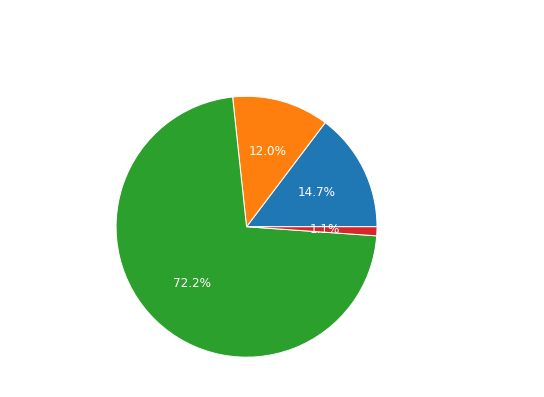

In [16]:
pie_chart("")

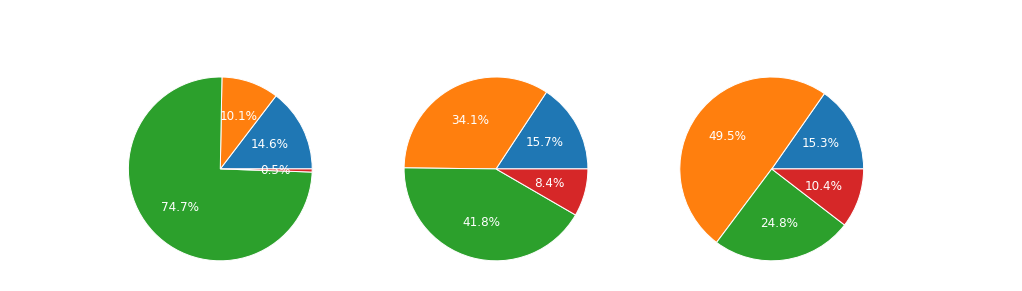

In [18]:
pie_chart("Dataset", layout=(1, 3))

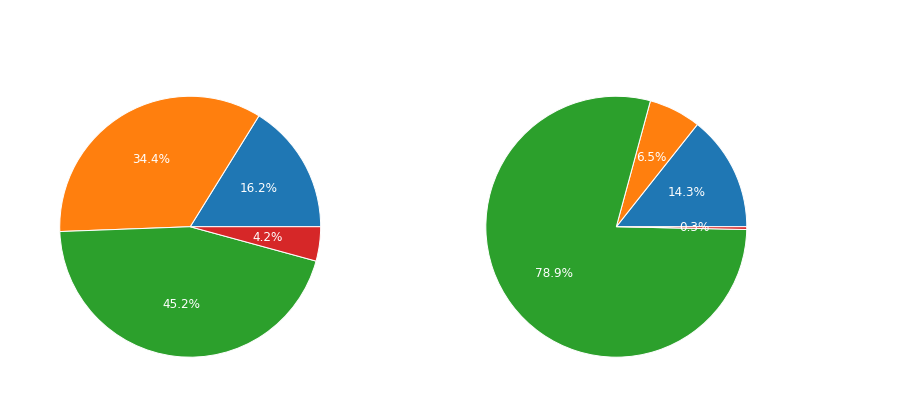

In [19]:
pie_chart("SIM")

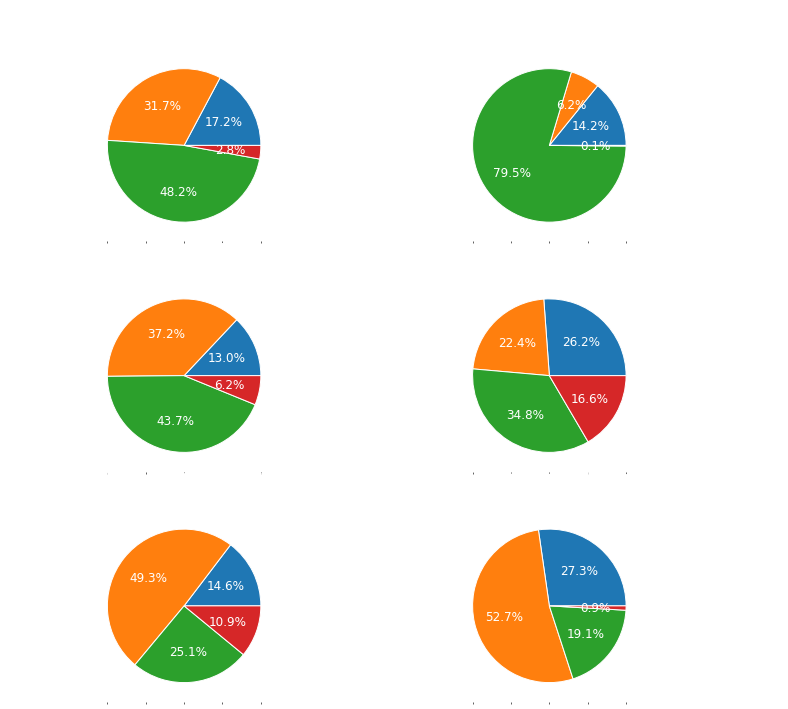

In [21]:
pie_chart(["Dataset", "SIM"],
          figsize=(12, 12),
          layout=(3, 2))

In [45]:
df_plot

,Species,Main Trait,SIM,Dataset,Can infer correct Value,None of the above,Can infer correct Entity,Can infer correct Quality
0,Lannea fruticosa,leaf apex,Bert,PlantNet,0,4,1,0
1,Strychnos spinosa,petiole,Bert,PlantNet,1,3,1,0
2,Keetia venosa,vein,Bert,PlantNet,0,4,1,0
3,Crescentia cujete,inflorescences,Bert,PlantNet,1,2,2,0
4,Crescentia cujete,inflorescences,Bert,PlantNet,1,2,2,0
...,...,...,...,...,...,...,...,...
21961,Acacia polyacantha ssp. campylacantha,flower shape,Bert,PlantNet,0,3,1,1
21962,Acacia polyacantha ssp. campylacantha,flower shape,Bert,PlantNet,0,4,1,0
21963,Maerua angolensis,plant type,Jacc,PlantNet,5,0,0,0
21964,Aphania senegalensis,leaf apex,Bert,PlantNet,0,4,1,0


### Plotly

In [69]:
df_plot.groupby(["SIM"]).sum()[['Can infer correct Value', 'None of the above', 'Can infer correct Entity', 'Can infer correct Quality']]

,Can infer correct Value,None of the above,Can infer correct Entity,Can infer correct Quality
SIM,,,,
Bert,3525,7504,9846,925
Jacc,12614,5686,69431,299


In [77]:
labels = ['Can infer correct Value', 'None of the above', 'Can infer correct Entity', 'Can infer correct Quality']

cafe_colors =  ['rgb(146, 123, 21)', 'rgb(177, 180, 34)', 'rgb(206, 206, 40)',
                'rgb(175, 51, 21)', 'rgb(35, 36, 21)']

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, 
                     values=df_plot.groupby(["SIM"]).sum()[['Can infer correct Value', 'None of the above', 'Can infer correct Entity', 'Can infer correct Quality']].iloc[0].values,
                     name="Bert Similarity",
                     marker_colors=cafe_colors),
              1, 1)
fig.add_trace(go.Pie(labels=labels, 
                     values=df_plot.groupby(["SIM"]).sum()[['Can infer correct Value', 'None of the above', 'Can infer correct Entity', 'Can infer correct Quality']].iloc[1].values,
                     name="Jaccard Similarity",
                     marker_colors=cafe_colors),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.6, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Trait Annotation",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='BERT', x=0.2, y=0.5, font_size=20, showarrow=False),
                 dict(text='JACC', x=0.8, y=0.5, font_size=20, showarrow=False)])
fig.show()

In [120]:
labels = ['Can infer correct Value', 'None of the above', 'Can infer correct Entity', 'Can infer correct Quality']

cafe_colors =  ['rgb(146, 123, 21)', 'rgb(177, 180, 34)', 'rgb(206, 206, 40)',
                'rgb(175, 51, 21)', 'rgb(35, 36, 21)']

irises_colors = ['rgb(33, 75, 99)', 'rgb(79, 129, 102)', 'rgb(151, 179, 100)',
                 'rgb(175, 49, 35)', 'rgb(36, 73, 147)']

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}],
                                           [{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])

# Add pie charts to each subplot
for i, sim in enumerate(df_plot["SIM"].unique()):
    for j, dataset in enumerate(df_plot["Dataset"].unique()):
        df_sub = df_plot[(df_plot["SIM"] == sim) & (df_plot["Dataset"] == dataset)]
        fig.add_trace(go.Pie(labels=labels, 
                             values=df_sub.groupby(["SIM", "Dataset"]).sum()[['Can infer correct Value', 'None of the above', 'Can infer correct Entity', 'Can infer correct Quality']].iloc[0].values,
                             name=sim + ' ' + dataset,
                             marker_colors=irises_colors),
                      i+1, j+1)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Trait Annotation",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='PlantNet Dataset Bert',  x=0.050, y=1.1, font_size=15, showarrow=False),
                 dict(text='Palm Dataset Bert',      x=0.500, y=1.1, font_size=15, showarrow=False),
                 dict(text='Caribbean Dataset Bert', x=0.950, y=1.1, font_size=15, showarrow=False),
                 dict(text='PlantNet Dataset Jacc',  x=0.050, y=-0.12, font_size=15, showarrow=False),
                 dict(text='Palm Dataset Jacc',      x=0.500, y=-0.12, font_size=15, showarrow=False),
                 dict(text='Caribbean Dataset Jacc', x=0.950, y=-0.12, font_size=15, showarrow=False)]
)

fig.show()

In [135]:
# df_melt = pd.melt(df_plot, id_vars=["Species", "Main Trait", "SIM", "Dataset"], 
#         value_vars=['Can infer correct Value', 'None of the above', 'Can infer correct Entity', 'Can infer correct Quality'],
#         var_name='None', value_name='value', col_level=None, ignore_index=True)

df_melt = pd.melt(df_plot, id_vars=["Species", "Main Trait", "SIM", "Dataset"], 
        value_vars=['Can infer correct Value', 'None of the above', 'Can infer correct Entity', 'Can infer correct Quality'],
        var_name='None', value_name='value', col_level=None, ignore_index=True)

df_melt

,Species,Main Trait,SIM,Dataset,None,value
0,Lannea fruticosa,leaf apex,Bert,PlantNet,Can infer correct Value,0
1,Strychnos spinosa,petiole,Bert,PlantNet,Can infer correct Value,1
2,Keetia venosa,vein,Bert,PlantNet,Can infer correct Value,0
3,Crescentia cujete,inflorescences,Bert,PlantNet,Can infer correct Value,1
4,Crescentia cujete,inflorescences,Bert,PlantNet,Can infer correct Value,1
...,...,...,...,...,...,...
87859,Acacia polyacantha ssp. campylacantha,flower shape,Bert,PlantNet,Can infer correct Quality,1
87860,Acacia polyacantha ssp. campylacantha,flower shape,Bert,PlantNet,Can infer correct Quality,0
87861,Maerua angolensis,plant type,Jacc,PlantNet,Can infer correct Quality,0
87862,Aphania senegalensis,leaf apex,Bert,PlantNet,Can infer correct Quality,0
